In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 'stix' is similar to Times New Roman
# If you want to use LaTeX to render all text (for more consistency)
# plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth'] = 0.5    # Axis line width
plt.rcParams['lines.linewidth'] = 1    # Line width
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Read ground truth and prediction

In [2]:
nt = 12

num_zones = 8

num_data = 200

# Ground truth
agg_PG_true = np.zeros((num_data, num_zones+1, nt))
agg_PG_pred = np.zeros((num_data, num_zones+1, nt))

# Read ground truth and prediction
for i in range(num_data):
    file_path  =f'../../res/IEEE_Case1354/model_evaluation/agg_PG/true/true_{i+1}.csv'
    ground_truth = pd.read_csv(file_path, header=None, index_col=None)
    agg_PG_true[i, :, :] = ground_truth.values.copy()

    file_path  =f'../../res/IEEE_Case1354/model_evaluation/agg_PG/pred/pred_{i+1}.csv'
    pred = pd.read_csv(file_path, header=None, index_col=None)
    agg_PG_pred[i, :, :] = pred.values.copy()

## One-on-one comparison

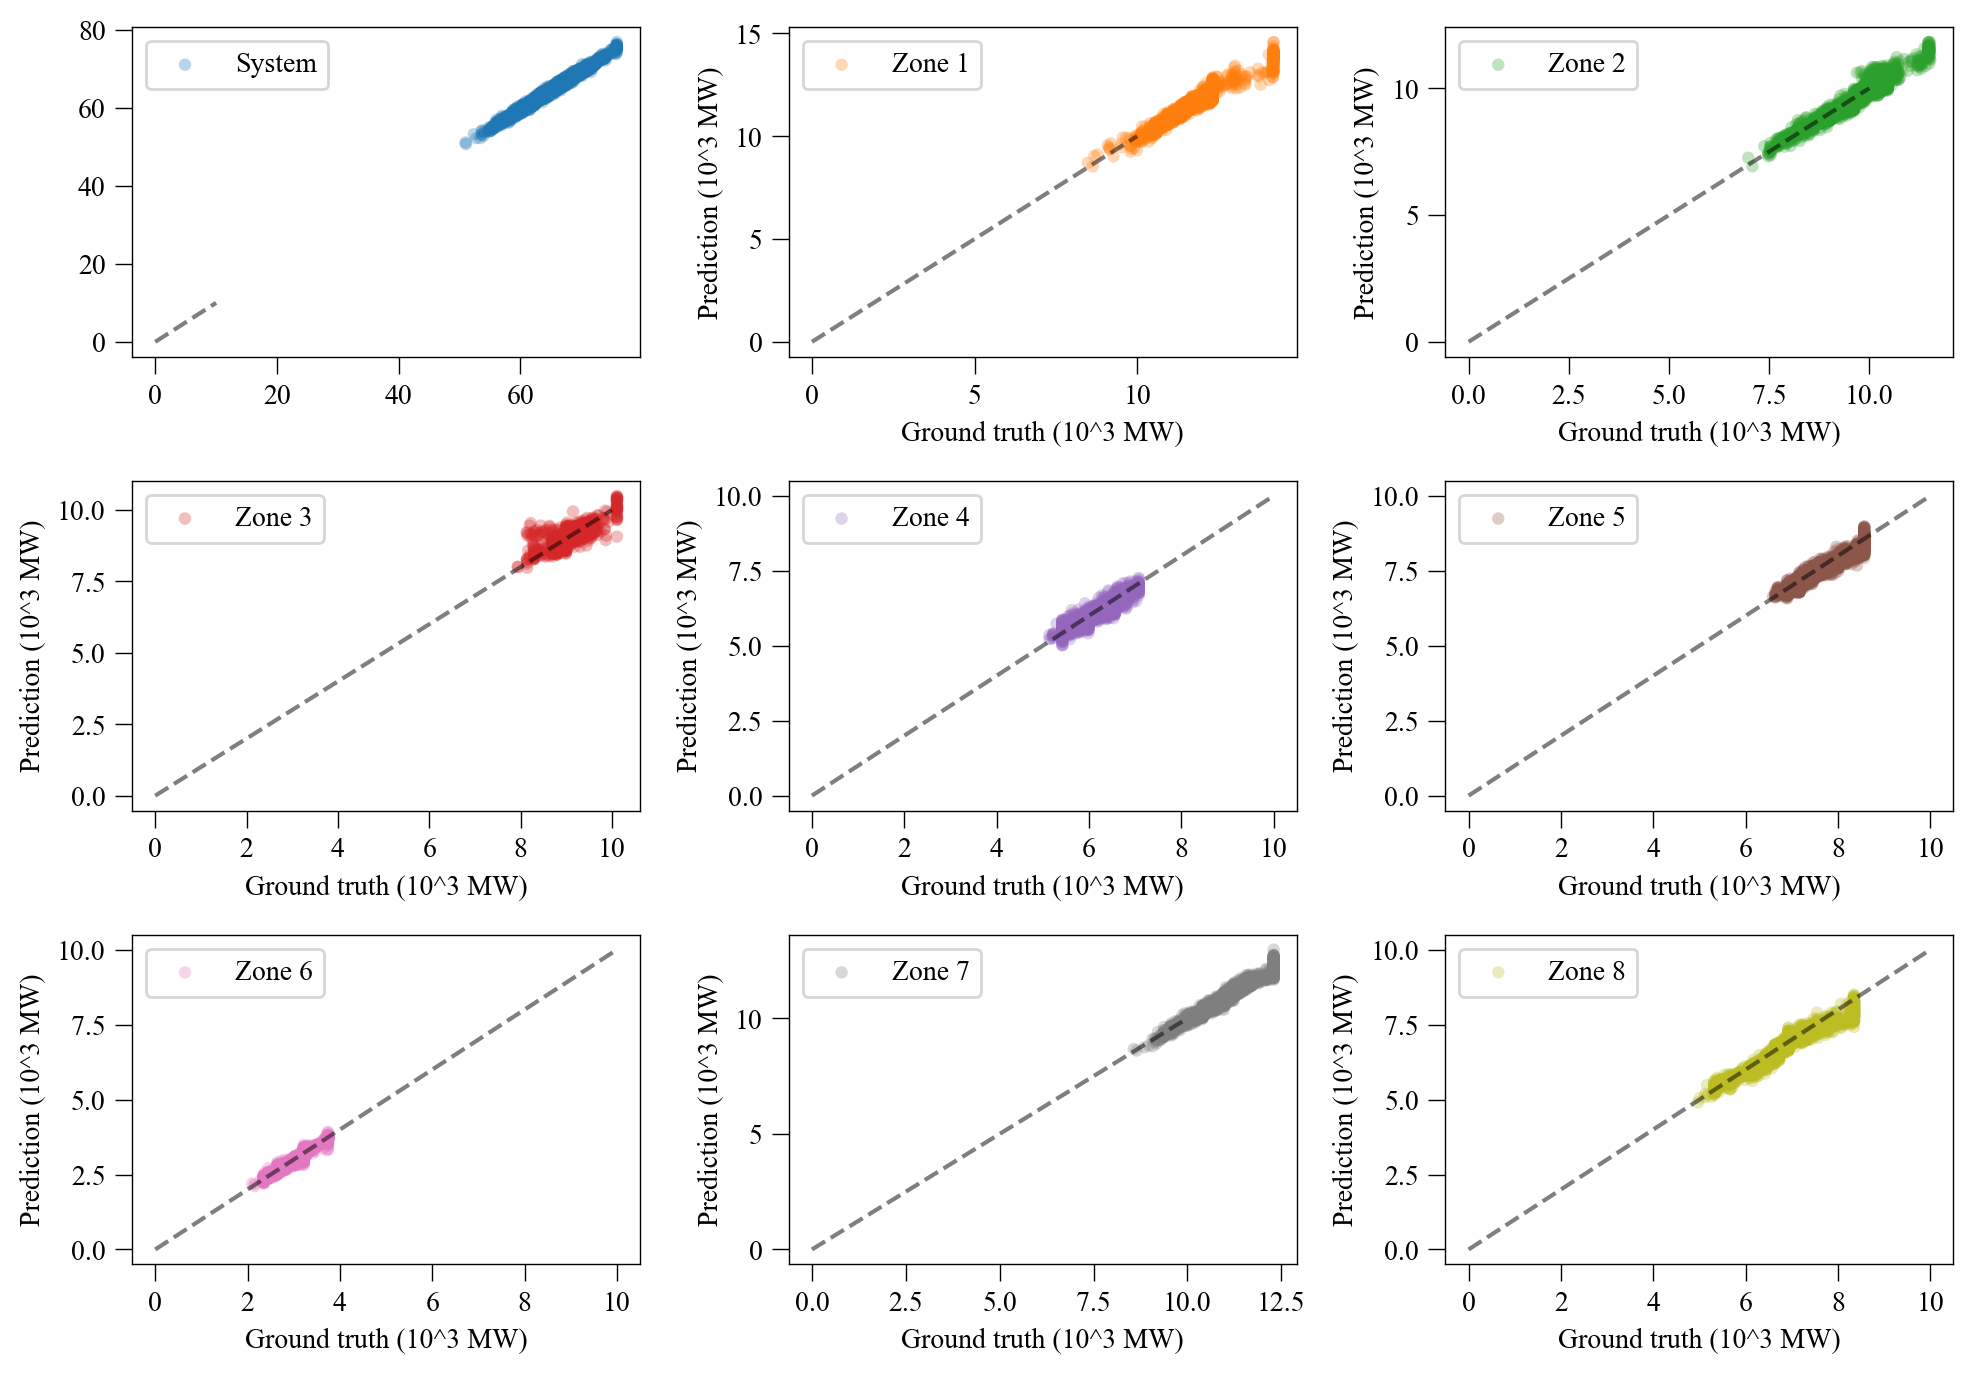

In [3]:
# System-level
fig = plt.figure(figsize=(10, 7))
x = np.linspace(0, 10, 100)
y = x

ax = fig.add_subplot(3, 3, 1)
ax.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
ax.scatter(agg_PG_true[:, 0, :].flatten()/1000, agg_PG_pred[:, 0, :].flatten()/1000, 
            s=20, c=colors[0], marker='o', edgecolors='none', alpha=0.3, label='System')
ax.legend(loc='upper left')

for i in range(1, num_zones+1):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
    ax.scatter(agg_PG_true[:, i, :].flatten()/1000, agg_PG_pred[:, i, :].flatten()/1000, 
                s=20, c=colors[i], marker='o', edgecolors='none', alpha=0.3, label=f'Zone {i}')
    # ax.set_xlim((2, 9))
    # ax.set_ylim((2, 9))
    ax.set_xlabel('Ground truth (10^3 MW)')
    ax.set_ylabel('Prediction (10^3 MW)')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()
plt.close('all')

## Calculate MRE

In [4]:
rela_err = (agg_PG_true - agg_PG_pred) / agg_PG_true * 100
MRE = np.mean(np.abs(rela_err), axis=0)

## Zone-level MRE

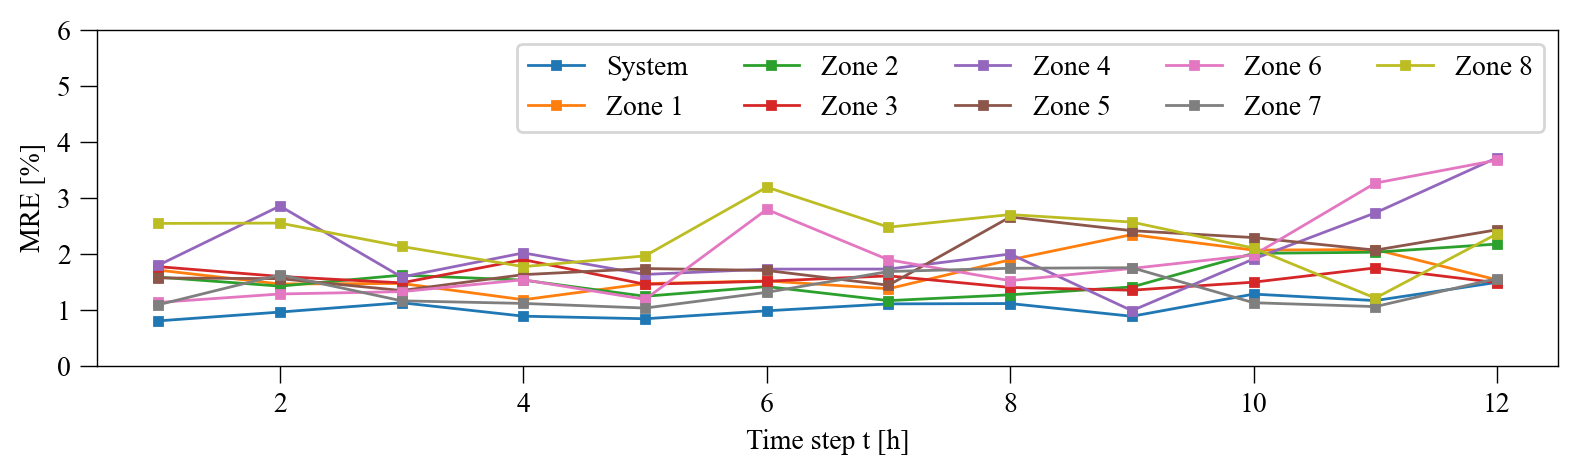

In [11]:
fig = plt.figure(figsize=(8, 2.5))
ax = fig.add_subplot(111)

# System
ax.plot(np.arange(1, 13), MRE[0, :], color=colors[0], linewidth=1, marker='s', markersize=3, label='System')
# Zones
for i in range(1, num_zones+1):
    ax.plot(np.arange(1, 13), MRE[i, :], color=colors[i],  linewidth=1, marker='s', markersize=3, label=f'Zone {i}')
    ax.set_xlabel('Time step t [h]')
    ax.set_ylabel('MRE [%]')
    ax.set_xlim((0.5, 12.5))
    ax.set_ylim(0, 6)
ax.legend(ncols=5)

plt.tight_layout()
plt.show()
# fig.savefig(f'../../res/IEEE_Case1354/model_evaluation/agg_PG_MRE.pdf', bbox_inches='tight')
plt.close('all')

In [8]:
# MRE table
columns = [f'T = {i}' for i in range(1, 13)]
MRE_table = pd.DataFrame(np.round(MRE, 3), columns=columns)
MRE_table

,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6,T = 7,T = 8,T = 9,T = 10,T = 11,T = 12
0,0.798,0.956,1.123,0.882,0.836,0.978,1.102,1.108,0.880,1.277,1.161,1.487
1,1.706,1.458,1.467,1.176,1.465,1.513,1.372,1.891,2.341,2.064,2.074,1.532
2,1.581,1.419,1.616,1.528,1.238,1.411,1.160,1.264,1.405,2.006,2.026,2.172
3,1.768,1.593,1.478,1.893,1.452,1.507,1.603,1.396,1.347,1.490,1.745,1.480
4,1.792,2.852,1.582,2.013,1.629,1.724,1.725,1.994,0.981,1.905,2.730,3.716
5,1.566,1.553,1.341,1.625,1.734,1.700,1.435,2.656,2.411,2.288,2.063,2.427
6,1.128,1.279,1.321,1.534,1.183,2.791,1.891,1.517,1.736,1.976,3.262,3.673
7,1.085,1.623,1.157,1.110,1.027,1.309,1.681,1.739,1.749,1.123,1.053,1.556
8,2.541,2.547,2.129,1.768,1.960,3.190,2.474,2.699,2.565,2.099,1.205,2.355


In [9]:
tex_code = MRE_table.to_latex(index=False, escape=False)
print(tex_code)

\begin{tabular}{rrrrrrrrrrrr}
\toprule
T = 1 & T = 2 & T = 3 & T = 4 & T = 5 & T = 6 & T = 7 & T = 8 & T = 9 & T = 10 & T = 11 & T = 12 \\
\midrule
0.798000 & 0.956000 & 1.123000 & 0.882000 & 0.836000 & 0.978000 & 1.102000 & 1.108000 & 0.880000 & 1.277000 & 1.161000 & 1.487000 \\
1.706000 & 1.458000 & 1.467000 & 1.176000 & 1.465000 & 1.513000 & 1.372000 & 1.891000 & 2.341000 & 2.064000 & 2.074000 & 1.532000 \\
1.581000 & 1.419000 & 1.616000 & 1.528000 & 1.238000 & 1.411000 & 1.160000 & 1.264000 & 1.405000 & 2.006000 & 2.026000 & 2.172000 \\
1.768000 & 1.593000 & 1.478000 & 1.893000 & 1.452000 & 1.507000 & 1.603000 & 1.396000 & 1.347000 & 1.490000 & 1.745000 & 1.480000 \\
1.792000 & 2.852000 & 1.582000 & 2.013000 & 1.629000 & 1.724000 & 1.725000 & 1.994000 & 0.981000 & 1.905000 & 2.730000 & 3.716000 \\
1.566000 & 1.553000 & 1.341000 & 1.625000 & 1.734000 & 1.700000 & 1.435000 & 2.656000 & 2.411000 & 2.288000 & 2.063000 & 2.427000 \\
1.128000 & 1.279000 & 1.321000 & 1.534000 & 1.183000 &